# Ensemble Learning

In this notebook file, Ensemble Learning method will be used with FabricWaste data for predict All Output Rates

In [1]:
#Libraries are being imported
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlibVersion

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import __version__ as sklearnVersion

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.metrics import MAE
from tensorflow.keras.callbacks import Callback
from tensorflow import __version__ as tensorflowVersion

from joblib import load, __version__ as joblibVersion

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('matplotlib Version: ' + matplotlibVersion)
print('sklearn Version: ' + sklearnVersion)
print('tensorflow Version: ' + tensorflowVersion)
print('joblib Version: ' + joblibVersion)

numpy Version: 1.23.5
pandas Version: 1.5.2
matplotlib Version: 3.6.2
sklearn Version: 1.2.0
tensorflow Version: 2.10.0
joblib Version: 1.1.1


In [3]:
#Constant is being defined
MODEL_NAME = 'Ensemble Learning'

In [4]:
#Function to draw Chart
def DrawChart(title, value, predicted):
    plt.figure(figsize = (12, 6))
    plt.title(title)
    plt.scatter(value, predicted)
    plt.plot(value, value, 'r')
    plt.legend(['Predictions', 'LineOfRealValues'])

In [5]:
#Class that defines the regression models to use, and model result information
class RegressionModel:
    def __init__(self, name, model, weight, needAdjust):
        self.name = name
        self.model = model
        self.weight = weight
        self.needAdjust = needAdjust

In [6]:
#The class to use for predicting with the Ensemble Learning method
class EnsemblePredictor:
    def __init__(self, regressorList):
        #list of regression models to use
        self.regressorList = regressorList

    #Method to make predictions
    def predict(self, dataX, outputShape):
        
        result = np.zeros(outputShape)
        #For each model
        for regressor in self.regressorList:
            
            #results are being predicted
            predict = regressor.model.predict(dataX)
            
            #results are being adjusted if it is needed
            if regressor.needAdjust:
                predict[predict < 0] = 0
                predict[predict > 8] = 8
            
            #the predictions are being multiplied by the weight value of the model and added to the result array
            #each model will have a weight between 0 and 1
            #this process applies Weighted Averaging Method for Ensemble Learning
            result += predict * regressor.weight

        return result

In [7]:
#resultFrame is being created by reading pkl files
resultFrame = pd.concat([pd.read_pickle('../../Model/MultiOutput/LinearRegression/ResultFrame.pkl'),
                         pd.read_pickle('../../Model/MultiOutput/RidgeRegression/ResultFrame.pkl'),
                         pd.read_pickle('../../Model/MultiOutput/PolynomialRegression/ResultFrame.pkl'),
                         pd.read_pickle('../../Model/MultiOutput/SVR/ResultFrame.pkl'),
                         pd.read_pickle('../../Model/MultiOutput/NeuralNetwork/ResultFrame.pkl')
                        ]).reset_index(drop = True)
resultFrame

,Model,Data,ColumName,MeanAbsoluteError,MeanSquaredError,SqrtMeanSquaredError
0,Linear Regression,Training,PrintErrorRate,0.447395,0.477898,0.691302
1,Linear Regression,Training,SewingErrorRate,0.809287,1.052912,1.026115
2,Linear Regression,Training,FabricStainRate,0.110747,0.033421,0.182814
3,Linear Regression,Training,FabricErrorRate,0.446201,0.408367,0.639036
4,Linear Regression,Training,EmbroideryErrorRate,0.108222,0.045823,0.214062
...,...,...,...,...,...,...
130,ANN,Test,EmbroideryErrorRate,0.168857,0.271128,0.520700
131,ANN,Test,MeasureErrorRate,0.175961,0.049140,0.221675
132,ANN,Test,SecondQualityRate,1.065034,2.361697,1.536781
133,ANN,Test,DefectRate,1.400232,4.050573,2.012604


In [8]:
#Since a new model that makes predictions with the results obtained 
#from more than one model will be prepared in this notebook file,
#weight calculation should be done based on average validation results
#test data is data that will only be used for control after adjustments have been made for any model
#This process can be considered as hyperparameter optimization
#If such processes are done according to the results of the test data, it will cause a kind of information leakage problem

#A dataFrame containing the results of each model on average validation data only is being created
validationResultFrame = resultFrame[(resultFrame['Data'] == 'Validation') & (resultFrame['ColumName'] == 'Average')]
validationResultFrame

,Model,Data,ColumName,MeanAbsoluteError,MeanSquaredError,SqrtMeanSquaredError
17,Linear Regression,Validation,Average,0.795401,2.117341,1.128186
44,Ridge Regression,Validation,Average,0.794439,2.112613,1.127049
71,Polynomial Regression,Validation,Average,1.511266,6.434683,2.069462
98,SVR,Validation,Average,0.756820,1.867065,1.082459
125,ANN,Validation,Average,0.738173,1.698438,1.030181


In [9]:
#Since weight calculations will be made via MeanSquaredError, a total value is being calculated on this value
validationTotalMSE = validationResultFrame['MeanSquaredError'].sum()
validationTotalMSE

14.2301404589422

In [10]:
#An empty array is being defined
dictionaryList = []

In [11]:
#For Linear Regression, the point is being calculated and added to a list
#Since the model with the lowest MeanSquaredError value should get the highest point
#the point of the models are being calculated by subtracting MeanSquaredError to the total score value
name = 'Linear Regression'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [12]:
#For Ridge Regression, the point is being calculated and added to a list
name = 'Ridge Regression'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [13]:
#For Polynomial Regression, the point is being calculated and added to a list
name = 'Polynomial Regression'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [14]:
#For Support Vector Regression, the point is being calculated and added to a list
name = 'SVR'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [15]:
#For Artificial Neural Network, the point is being calculated and added to a list
name = 'ANN'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [16]:
#RegressorFrame is being created according to dictionaryList
RegressorFrame = pd.DataFrame(dictionaryList)
RegressorFrame

,Name,Point
0,Linear Regression,12.112799
1,Ridge Regression,12.117528
2,Polynomial Regression,7.795457
3,SVR,12.363075
4,ANN,12.531702


In [17]:
#A total point value is being calculated over the RegressorFrame
totalPoint = RegressorFrame['Point'].sum()
totalPoint

56.9205618357688

In [18]:
#point rates are being calculated by dividing each model point by the total point
RegressorFrame['PointRate'] = RegressorFrame['Point'].apply(lambda point : point / totalPoint)
RegressorFrame

,Name,Point,PointRate
0,Linear Regression,12.112799,0.212802
1,Ridge Regression,12.117528,0.212885
2,Polynomial Regression,7.795457,0.136953
3,SVR,12.363075,0.217199
4,ANN,12.531702,0.220161


In [19]:
#sum of the ratios is equal to 1 is being shown
RegressorFrame['PointRate'].sum()

1.0

In [20]:
#A list for RegressionModel objects is being created
regressionModels = []

In [21]:
#RegressionModel container object for Linear Regression model is being appended to the list
#Since this model does not need manual adjustment, needAdjust of the container object is defined as False
row = RegressorFrame[RegressorFrame['Name'] == 'Linear Regression']
regressor = load('../../Model/MultiOutput/LinearRegression/LinearRegression.joblib')
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], True))

In [22]:
#RegressionModel container object for Ridge Regression model is being appended to the list
#Since this model does not need manual adjustment, needAdjust of the container object is defined as False
row = RegressorFrame[RegressorFrame['Name'] == 'Ridge Regression']
regressor = load('../../Model/MultiOutput/RidgeRegression/RidgeRegression.joblib')
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], True))

In [23]:
#RegressionModel container object for Ridge Regression model is being appended to the list
#Since this model does need manual adjustment, needAdjust of the container object is defined as True
#The values out of the logical limits from the prediction results obtained from this model
#will be used by manually bringing them to the limits
#In fact, when used in this way, the success rate of this model on the validation data is quite high
#However, this results was not used in the weight calculation of this model as it was achieved manually
row = RegressorFrame[RegressorFrame['Name'] == 'Polynomial Regression']
regressor = Pipeline([('PolyFeature', load('../../Model/MultiOutput/PolynomialRegression/PolyFeature.joblib')),
                      ('Ridge', load('../../Model/MultiOutput/PolynomialRegression/RidgeRegression.joblib'))])
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], True))

In [24]:
#RegressionModel container object for SVR model is being appended to the list
#Since this model does not need manual adjustment, needAdjust of the container object is defined as False
row = RegressorFrame[RegressorFrame['Name'] == 'SVR']
regressor =  load('../../Model/MultiOutput/SVR/SVR.joblib')
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], True))

In [25]:
#RegressionModel container object for ANN model is being appended to the list
#Since this model does not need manual adjustment, needAdjust of the container object is defined as False
row = RegressorFrame[RegressorFrame['Name'] == 'ANN']
regressor =  load_model('../../Model/MultiOutput/NeuralNetwork/ANN.h5')
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], True))

In [26]:
#An EnsemblePredictor object is being created
ensemblePredictor = EnsemblePredictor(regressionModels)

In [27]:
#testFrame is being created by reading a pkl file
testFrame = pd.read_pickle("../../../Data/DataSplit/Test.pkl")
testFrame.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PrintError,SewingError,FabricStain,FabricError,EmbroideryError,MeasureError,SecondQuality,CalculatedSecondQuality,Defect,OrderQuantity
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,2,15,5,2,0,2,25,26,32,420
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0,3,0,1,0,0,4,4,5,150
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,93,26,2,3,0,0,123,124,143,4395
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0,3,1,0,0,0,4,4,5,200
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0,0,0,0,5,0,5,5,7,170


In [28]:
#Information of testFrame is being printed
testFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PC0                      25 non-null     float64
 1   PC1                      25 non-null     float64
 2   PC2                      25 non-null     float64
 3   PC3                      25 non-null     float64
 4   PC4                      25 non-null     float64
 5   PC5                      25 non-null     float64
 6   PC6                      25 non-null     float64
 7   PC7                      25 non-null     float64
 8   PC8                      25 non-null     float64
 9   PC9                      25 non-null     float64
 10  PC10                     25 non-null     float64
 11  PC11                     25 non-null     float64
 12  PC12                     25 non-null     float64
 13  PC13                     25 non-null     float64
 14  PC14                     25 

In [29]:
#Statistical information of testFrame part to use is being printed
testFrame.loc[:, : 'DefectRate'].describe()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC21,PC22,PrintErrorRate,SewingErrorRate,FabricStainRate,FabricErrorRate,EmbroideryErrorRate,MeasureErrorRate,SecondQualityRate,DefectRate
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.013024,0.454578,-0.202597,0.279146,-0.191783,0.205207,0.494423,-0.527151,0.060211,-0.557505,...,0.567818,0.239675,0.003294,0.015150,0.000676,0.003143,0.001066,0.000173,0.023501,0.041856
std,2.863422,2.356419,2.651003,2.553474,1.846505,1.743946,2.241005,1.566362,1.592350,1.674245,...,1.379990,0.852453,0.005886,0.015264,0.002298,0.003419,0.005205,0.000864,0.016756,0.020805
min,-2.551436,-4.813578,-5.463644,-4.955933,-2.546559,-3.651559,-3.551327,-2.782388,-2.901741,-5.528565,...,-1.965344,-2.033394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004032,0.016129
25%,-0.758804,-1.143406,-1.556957,-1.558052,-1.478593,-0.849267,-0.887723,-1.783384,-0.906136,-0.831912,...,-0.529781,-0.181202,0.000000,0.004693,0.000000,0.000000,0.000000,0.000000,0.011312,0.029144
50%,-0.379232,0.395125,-0.315427,0.275050,-0.512525,0.087782,0.200355,-0.501114,-0.104364,-0.430639,...,0.848378,0.480764,0.000000,0.009050,0.000000,0.003546,0.000000,0.000000,0.020590,0.036458
75%,0.085605,1.995143,0.415892,2.469710,0.351512,1.472206,0.870501,0.563257,0.579843,0.518843,...,1.588861,0.707311,0.004255,0.018182,0.000000,0.004545,0.000000,0.000000,0.027273,0.048193
max,12.352104,3.858221,7.682068,4.371193,5.226237,3.279513,5.463404,2.711760,3.024043,1.731993,...,3.393513,2.035233,0.020480,0.065657,0.010799,0.013158,0.026042,0.004320,0.070707,0.101010


In [30]:
#The outputName list is being created by getting the column names of the output features in order
outputName = testFrame.loc[:, 'PrintErrorRate' : 'DefectRate'].columns.tolist()
outputName

['PrintErrorRate',
 'SewingErrorRate',
 'FabricStainRate',
 'FabricErrorRate',
 'EmbroideryErrorRate',
 'MeasureErrorRate',
 'SecondQualityRate',
 'DefectRate']

In [31]:
#testX is being created with input features of testFrame
testX = testFrame.loc[:, : 'PC22'].values
testX.shape

(25, 23)

In [32]:
#testY is being created with Error Rate features of testFrame
#Rates in the 0-1 range are being multiplied by 100 to get them into the 0-100 range
testY = testFrame.loc[:, 'PrintErrorRate' : 'DefectRate'].values * 100
testY.shape

(25, 8)

In [33]:
#Predictions are being made on testX  by ensemblePredictor
predictions = ensemblePredictor.predict(testX, testY.shape)
predictions.shape

1/1 [==============================] - 0s 141ms/step


(25, 8)

In [34]:
#resultFrame based on predictions and real values is being created
resultDict = {'Model' : [], 'Data' : [], 'ColumName' : [], 'MeanAbsoluteError' : [],
              'MeanSquaredError' : [], 'SqrtMeanSquaredError' : []}
for i in range(predictions.shape[1]):
    resultDict['Model'].append(MODEL_NAME)
    resultDict['Data'].append('Test')
    resultDict['ColumName'].append(outputName[i])
    resultDict['MeanAbsoluteError'].append(mean_absolute_error(testY[:,i], predictions[:,i]))
    resultDict['MeanSquaredError'].append(mean_squared_error(testY[:,i], predictions[:,i]))
    resultDict['SqrtMeanSquaredError'].append(np.sqrt(mean_squared_error(testY[:,i], predictions[:,i])))
    
resultDict['Model'].append(MODEL_NAME)
resultDict['Data'].append('Test')
resultDict['ColumName'].append('Average')
resultDict['MeanAbsoluteError'].append(np.mean(resultDict['MeanAbsoluteError']))
resultDict['MeanSquaredError'].append(np.mean(resultDict['MeanSquaredError']))
resultDict['SqrtMeanSquaredError'].append(np.mean(resultDict['SqrtMeanSquaredError']))

resultFrame = pd.concat([resultFrame, pd.DataFrame(resultDict)]).reset_index(drop = True)
resultFrame

,Model,Data,ColumName,MeanAbsoluteError,MeanSquaredError,SqrtMeanSquaredError
0,Linear Regression,Training,PrintErrorRate,0.447395,0.477898,0.691302
1,Linear Regression,Training,SewingErrorRate,0.809287,1.052912,1.026115
2,Linear Regression,Training,FabricStainRate,0.110747,0.033421,0.182814
3,Linear Regression,Training,FabricErrorRate,0.446201,0.408367,0.639036
4,Linear Regression,Training,EmbroideryErrorRate,0.108222,0.045823,0.214062
...,...,...,...,...,...,...
139,Ensemble Learning,Test,EmbroideryErrorRate,0.183306,0.256393,0.506353
140,Ensemble Learning,Test,MeasureErrorRate,0.206789,0.108979,0.330119
141,Ensemble Learning,Test,SecondQualityRate,1.051585,1.804957,1.343487
142,Ensemble Learning,Test,DefectRate,1.413430,3.444573,1.855956


In [35]:
#A dataFrame containing the results of each model on average test data only is being created
testResultFrame = resultFrame[(resultFrame['Data'] == 'Test') & (resultFrame['ColumName'] == 'Average')]
testResultFrame

,Model,Data,ColumName,MeanAbsoluteError,MeanSquaredError,SqrtMeanSquaredError
26,Linear Regression,Test,Average,0.645611,1.082458,0.854555
53,Ridge Regression,Test,Average,0.644625,1.080140,0.853526
80,Polynomial Regression,Test,Average,1.478727,6.132207,2.264873
107,SVR,Test,Average,0.576314,1.084036,0.836196
134,ANN,Test,Average,0.577109,1.173361,0.857098
143,Ensemble Learning,Test,Average,0.596236,1.026487,0.841996


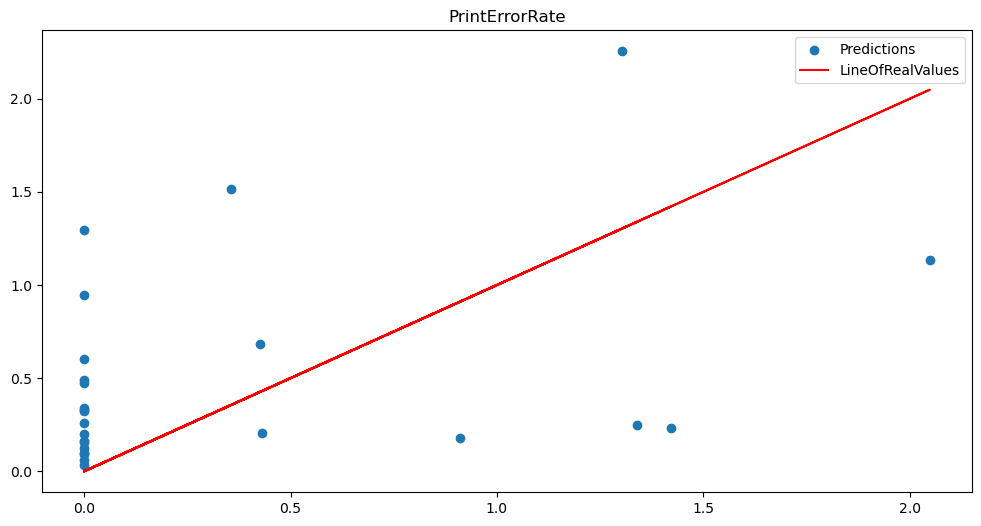

In [36]:
#Chart to show the closeness of the PrintErrorRate predictions to the true values is being plaotted
index = 0
DrawChart(outputName[index], testY[:, index], predictions[:, index])

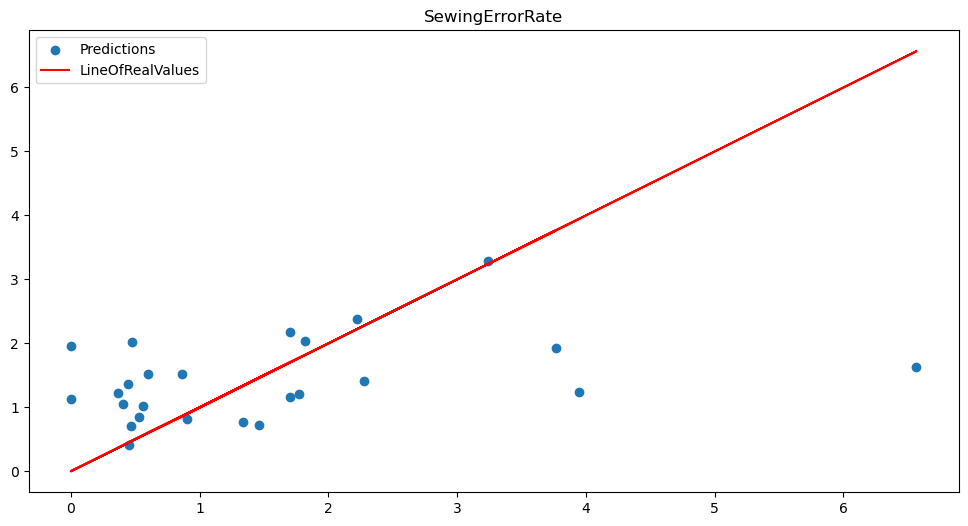

In [37]:
#Chart to show the closeness of the SewingErrorRate predictions to the true values is being plaotted
index = 1
DrawChart(outputName[index], testY[:, index], predictions[:, index])

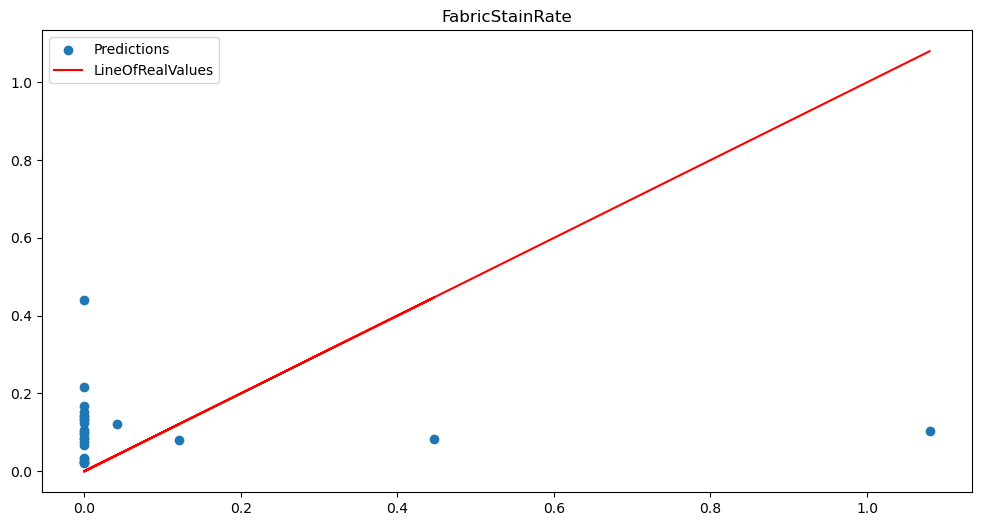

In [38]:
#Chart to show the closeness of the FabricStainRate predictions to the true values is being plaotted
index = 2
DrawChart(outputName[index], testY[:, index], predictions[:, index])

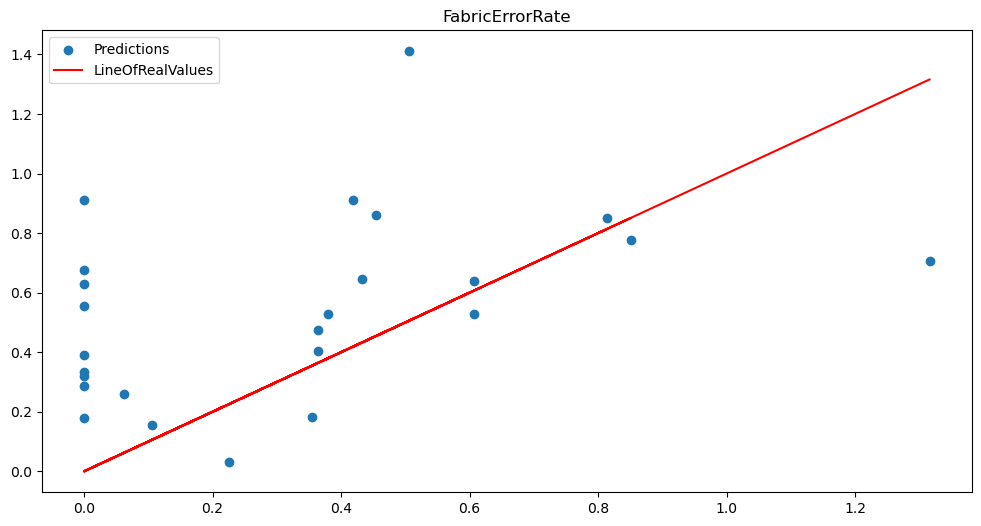

In [39]:
#Chart to show the closeness of the FabricErrorRate predictions to the true values is being plaotted
index = 3
DrawChart(outputName[index], testY[:, index], predictions[:, index])

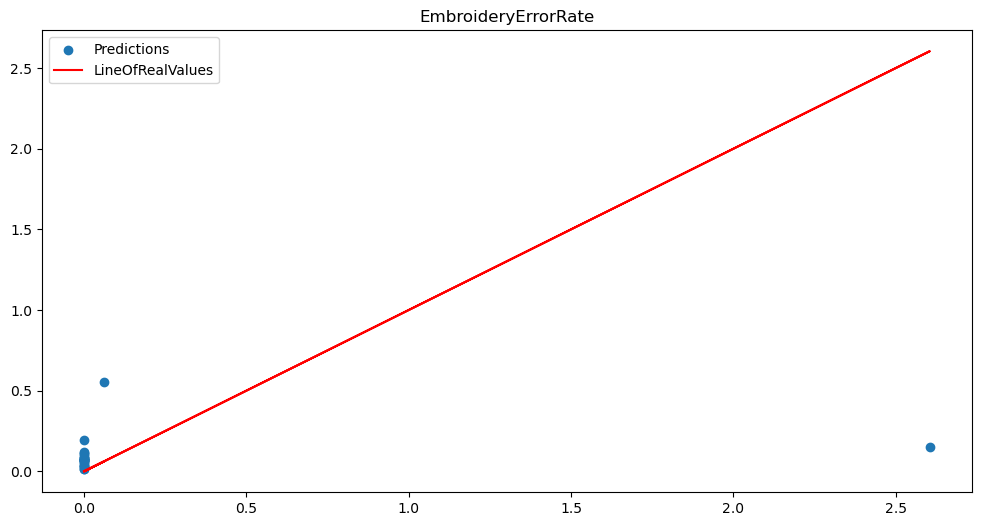

In [40]:
#Chart to show the closeness of the EmbroideryErrorRate predictions to the true values is being plaotted
index = 4
DrawChart(outputName[index], testY[:, index], predictions[:, index])

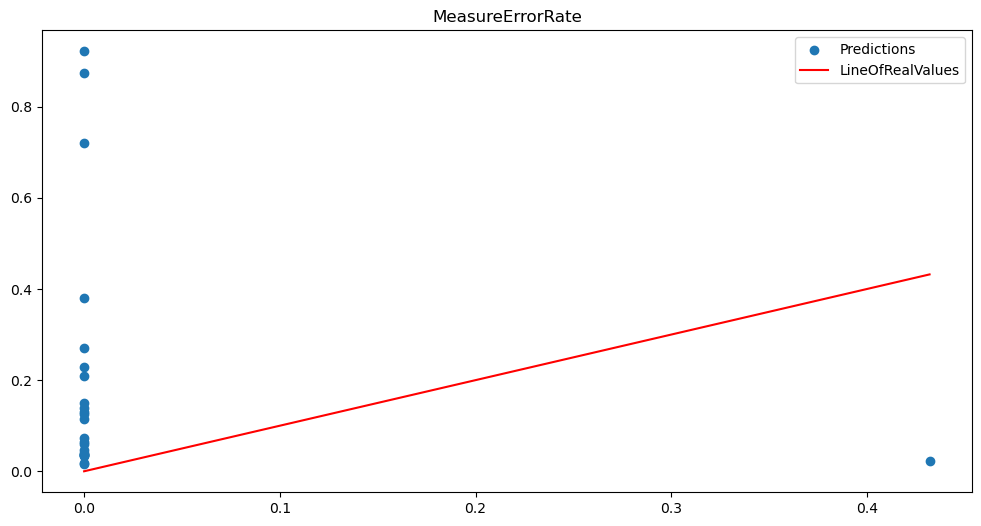

In [41]:
#Chart to show the closeness of the MeasureErrorRate predictions to the true values is being plaotted
index = 5
DrawChart(outputName[index], testY[:, index], predictions[:, index])

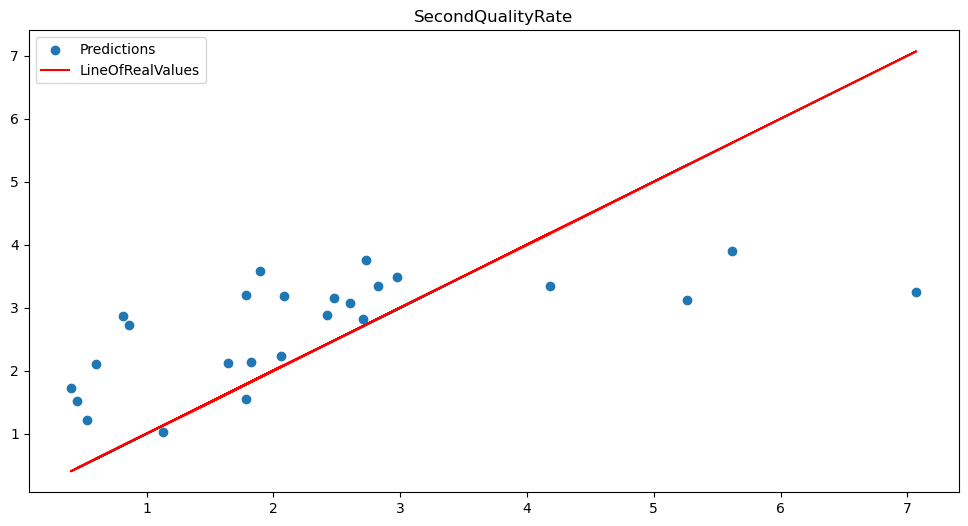

In [42]:
#Chart to show the closeness of the SecondQualityRate predictions to the true values is being plaotted
index = 6
DrawChart(outputName[index], testY[:, index], predictions[:, index])

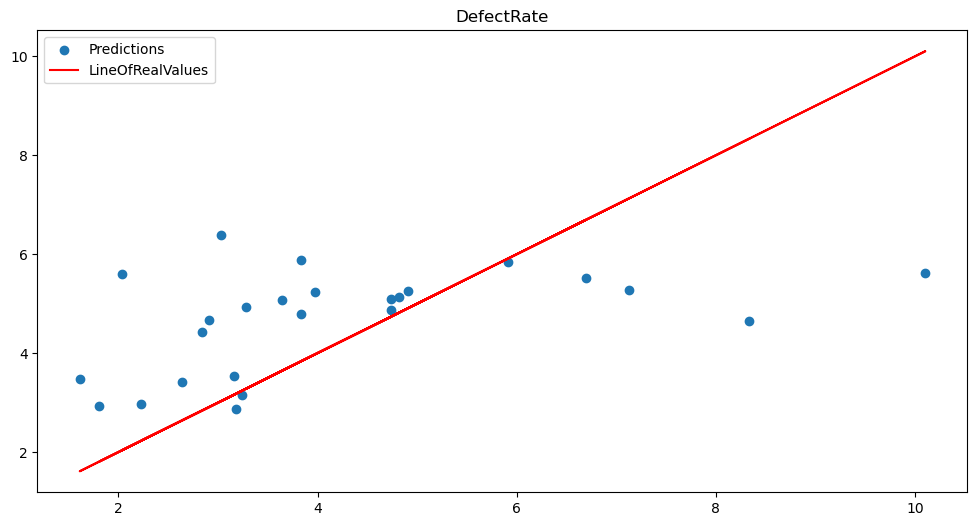

In [43]:
#Chart to show the closeness of the DefectRate predictions to the true values is being plaotted
index = 7
DrawChart(outputName[index], testY[:, index], predictions[:, index])

In [44]:
#Predictions are being appended to testFrame
testFrame[['PredictedPrintErrorRate', 'PredictedSewingErrorRate', 'PredictedFabricStainRate',
           'PredictedFabricErrorRate', 'PredictedEmbroideryErrorRate', 'PredictedMeasureErrorRate',
           'PredictedSecondQualityRate', 'PredictedDefectRate']] = predictions / 100
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,Defect,OrderQuantity,PredictedPrintErrorRate,PredictedSewingErrorRate,PredictedFabricStainRate,PredictedFabricErrorRate,PredictedEmbroideryErrorRate,PredictedMeasureErrorRate,PredictedSecondQualityRate,PredictedDefectRate
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,32,420,0.002058,0.032794,0.001046,0.006466,0.000689,0.000219,0.038983,0.052825
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,5,150,0.001590,0.020292,0.001013,0.005293,0.001161,0.000405,0.028791,0.063839
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,143,4395,0.011352,0.010265,0.001222,0.002579,0.000115,0.001262,0.028199,0.035446
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,5,200,0.009483,0.007701,0.000837,0.002864,0.000712,0.001293,0.015581,0.029755
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,7,170,0.004743,0.019593,0.001419,0.006287,0.001515,0.003808,0.030715,0.050797
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,18,450,0.002612,0.023768,0.001049,0.006381,0.000760,0.000347,0.033368,0.047851
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,18,250,0.000587,0.019268,0.000243,0.009094,0.000936,0.000191,0.033369,0.055173
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,9,210,0.006821,0.011682,0.001320,0.007767,0.000834,0.008735,0.034922,0.058832
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,10,190,0.002302,0.020238,0.004399,0.006763,0.000169,0.002089,0.035816,0.048775
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,4,220,0.002007,0.010458,0.000685,0.003332,0.000676,0.000651,0.017280,0.034835


In [45]:
#PredictedQuantity is being calculated according to OrderQuantity

#Equation Example
#OrderQuantity = PredictedQuantity - PredictedQuantity * PredictedSecondQualityRate
#OrderQuantity = PredictedQuantity * (1 - PredictedSecondQualityRate)
#PredictedQuantity = OrderQuantity / (1 - PredictedSecondQualityRate)

testFrame['PredictedQuantity'] = testFrame.apply(lambda row : 
                                                math.ceil(row['OrderQuantity'] / (1 - row['PredictedSecondQualityRate'])),
                                                axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,OrderQuantity,PredictedPrintErrorRate,PredictedSewingErrorRate,PredictedFabricStainRate,PredictedFabricErrorRate,PredictedEmbroideryErrorRate,PredictedMeasureErrorRate,PredictedSecondQualityRate,PredictedDefectRate,PredictedQuantity
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,420,0.002058,0.032794,0.001046,0.006466,0.000689,0.000219,0.038983,0.052825,438
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,150,0.001590,0.020292,0.001013,0.005293,0.001161,0.000405,0.028791,0.063839,155
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,4395,0.011352,0.010265,0.001222,0.002579,0.000115,0.001262,0.028199,0.035446,4523
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,200,0.009483,0.007701,0.000837,0.002864,0.000712,0.001293,0.015581,0.029755,204
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,170,0.004743,0.019593,0.001419,0.006287,0.001515,0.003808,0.030715,0.050797,176
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,450,0.002612,0.023768,0.001049,0.006381,0.000760,0.000347,0.033368,0.047851,466
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,250,0.000587,0.019268,0.000243,0.009094,0.000936,0.000191,0.033369,0.055173,259
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,210,0.006821,0.011682,0.001320,0.007767,0.000834,0.008735,0.034922,0.058832,218
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,190,0.002302,0.020238,0.004399,0.006763,0.000169,0.002089,0.035816,0.048775,198
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,220,0.002007,0.010458,0.000685,0.003332,0.000676,0.000651,0.017280,0.034835,224


In [46]:
#PredictedPrintError is being calculated

#Equation Example
#PredictedPrintError = PredictedQuantity * PredictedPrintErrorRate

testFrame['PredictedPrintError'] = testFrame.apply(lambda row : 
                                                math.ceil(row['PredictedQuantity'] * row['PredictedPrintErrorRate']), axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PredictedPrintErrorRate,PredictedSewingErrorRate,PredictedFabricStainRate,PredictedFabricErrorRate,PredictedEmbroideryErrorRate,PredictedMeasureErrorRate,PredictedSecondQualityRate,PredictedDefectRate,PredictedQuantity,PredictedPrintError
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,0.002058,0.032794,0.001046,0.006466,0.000689,0.000219,0.038983,0.052825,438,1
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0.001590,0.020292,0.001013,0.005293,0.001161,0.000405,0.028791,0.063839,155,1
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,0.011352,0.010265,0.001222,0.002579,0.000115,0.001262,0.028199,0.035446,4523,52
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0.009483,0.007701,0.000837,0.002864,0.000712,0.001293,0.015581,0.029755,204,2
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0.004743,0.019593,0.001419,0.006287,0.001515,0.003808,0.030715,0.050797,176,1
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,0.002612,0.023768,0.001049,0.006381,0.000760,0.000347,0.033368,0.047851,466,2
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,0.000587,0.019268,0.000243,0.009094,0.000936,0.000191,0.033369,0.055173,259,1
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,0.006821,0.011682,0.001320,0.007767,0.000834,0.008735,0.034922,0.058832,218,2
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0.002302,0.020238,0.004399,0.006763,0.000169,0.002089,0.035816,0.048775,198,1
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0.002007,0.010458,0.000685,0.003332,0.000676,0.000651,0.017280,0.034835,224,1


In [47]:
#PredictedSewingError is being calculated

#Equation Example
#PredictedSewingError = PredictedQuantity * PredictedSewingErrorRate

testFrame['PredictedSewingError'] = testFrame.apply(lambda row : 
                                                math.ceil(row['PredictedQuantity'] * row['PredictedSewingErrorRate']), axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PredictedSewingErrorRate,PredictedFabricStainRate,PredictedFabricErrorRate,PredictedEmbroideryErrorRate,PredictedMeasureErrorRate,PredictedSecondQualityRate,PredictedDefectRate,PredictedQuantity,PredictedPrintError,PredictedSewingError
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,0.032794,0.001046,0.006466,0.000689,0.000219,0.038983,0.052825,438,1,15
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0.020292,0.001013,0.005293,0.001161,0.000405,0.028791,0.063839,155,1,4
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,0.010265,0.001222,0.002579,0.000115,0.001262,0.028199,0.035446,4523,52,47
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0.007701,0.000837,0.002864,0.000712,0.001293,0.015581,0.029755,204,2,2
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0.019593,0.001419,0.006287,0.001515,0.003808,0.030715,0.050797,176,1,4
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,0.023768,0.001049,0.006381,0.000760,0.000347,0.033368,0.047851,466,2,12
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,0.019268,0.000243,0.009094,0.000936,0.000191,0.033369,0.055173,259,1,5
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,0.011682,0.001320,0.007767,0.000834,0.008735,0.034922,0.058832,218,2,3
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0.020238,0.004399,0.006763,0.000169,0.002089,0.035816,0.048775,198,1,5
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0.010458,0.000685,0.003332,0.000676,0.000651,0.017280,0.034835,224,1,3


In [48]:
#PredictedFabricStain is being calculated

#Equation Example
#PredictedFabricStain = PredictedQuantity * PredictedFabricStainRate

testFrame['PredictedFabricStain'] = testFrame.apply(lambda row : 
                                                math.ceil(row['PredictedQuantity'] * row['PredictedFabricStainRate']), axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PredictedFabricStainRate,PredictedFabricErrorRate,PredictedEmbroideryErrorRate,PredictedMeasureErrorRate,PredictedSecondQualityRate,PredictedDefectRate,PredictedQuantity,PredictedPrintError,PredictedSewingError,PredictedFabricStain
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,0.001046,0.006466,0.000689,0.000219,0.038983,0.052825,438,1,15,1
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0.001013,0.005293,0.001161,0.000405,0.028791,0.063839,155,1,4,1
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,0.001222,0.002579,0.000115,0.001262,0.028199,0.035446,4523,52,47,6
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0.000837,0.002864,0.000712,0.001293,0.015581,0.029755,204,2,2,1
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0.001419,0.006287,0.001515,0.003808,0.030715,0.050797,176,1,4,1
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,0.001049,0.006381,0.000760,0.000347,0.033368,0.047851,466,2,12,1
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,0.000243,0.009094,0.000936,0.000191,0.033369,0.055173,259,1,5,1
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,0.001320,0.007767,0.000834,0.008735,0.034922,0.058832,218,2,3,1
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0.004399,0.006763,0.000169,0.002089,0.035816,0.048775,198,1,5,1
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0.000685,0.003332,0.000676,0.000651,0.017280,0.034835,224,1,3,1


In [49]:
#PredictedFabricError is being calculated

#Equation Example
#PredictedFabricError = PredictedQuantity * PredictedFabricErrorRate

testFrame['PredictedFabricError'] = testFrame.apply(lambda row : 
                                                math.ceil(row['PredictedQuantity'] * row['PredictedFabricErrorRate']), axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PredictedFabricErrorRate,PredictedEmbroideryErrorRate,PredictedMeasureErrorRate,PredictedSecondQualityRate,PredictedDefectRate,PredictedQuantity,PredictedPrintError,PredictedSewingError,PredictedFabricStain,PredictedFabricError
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,0.006466,0.000689,0.000219,0.038983,0.052825,438,1,15,1,3
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0.005293,0.001161,0.000405,0.028791,0.063839,155,1,4,1,1
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,0.002579,0.000115,0.001262,0.028199,0.035446,4523,52,47,6,12
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0.002864,0.000712,0.001293,0.015581,0.029755,204,2,2,1,1
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0.006287,0.001515,0.003808,0.030715,0.050797,176,1,4,1,2
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,0.006381,0.000760,0.000347,0.033368,0.047851,466,2,12,1,3
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,0.009094,0.000936,0.000191,0.033369,0.055173,259,1,5,1,3
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,0.007767,0.000834,0.008735,0.034922,0.058832,218,2,3,1,2
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0.006763,0.000169,0.002089,0.035816,0.048775,198,1,5,1,2
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0.003332,0.000676,0.000651,0.017280,0.034835,224,1,3,1,1


In [50]:
#PredictedEmbroideryError is being calculated

#Equation Example
#PredictedEmbroideryError = PredictedQuantity * PredictedEmbroideryErrorRate

testFrame['PredictedEmbroideryError'] = testFrame.apply(lambda row : 
                                                    math.ceil(row['PredictedQuantity'] * row['PredictedEmbroideryErrorRate']),
                                                    axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PredictedEmbroideryErrorRate,PredictedMeasureErrorRate,PredictedSecondQualityRate,PredictedDefectRate,PredictedQuantity,PredictedPrintError,PredictedSewingError,PredictedFabricStain,PredictedFabricError,PredictedEmbroideryError
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,0.000689,0.000219,0.038983,0.052825,438,1,15,1,3,1
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0.001161,0.000405,0.028791,0.063839,155,1,4,1,1,1
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,0.000115,0.001262,0.028199,0.035446,4523,52,47,6,12,1
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0.000712,0.001293,0.015581,0.029755,204,2,2,1,1,1
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0.001515,0.003808,0.030715,0.050797,176,1,4,1,2,1
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,0.000760,0.000347,0.033368,0.047851,466,2,12,1,3,1
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,0.000936,0.000191,0.033369,0.055173,259,1,5,1,3,1
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,0.000834,0.008735,0.034922,0.058832,218,2,3,1,2,1
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0.000169,0.002089,0.035816,0.048775,198,1,5,1,2,1
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0.000676,0.000651,0.017280,0.034835,224,1,3,1,1,1


In [51]:
#PredictedMeasureError is being calculated

#Equation Example
#PredictedMeasureError = PredictedQuantity * PredictedMeasureErrorRate

testFrame['PredictedMeasureError'] = testFrame.apply(lambda row : 
                                                    math.ceil(row['PredictedQuantity'] * row['PredictedMeasureErrorRate']),
                                                    axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PredictedMeasureErrorRate,PredictedSecondQualityRate,PredictedDefectRate,PredictedQuantity,PredictedPrintError,PredictedSewingError,PredictedFabricStain,PredictedFabricError,PredictedEmbroideryError,PredictedMeasureError
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,0.000219,0.038983,0.052825,438,1,15,1,3,1,1
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0.000405,0.028791,0.063839,155,1,4,1,1,1,1
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,0.001262,0.028199,0.035446,4523,52,47,6,12,1,6
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0.001293,0.015581,0.029755,204,2,2,1,1,1,1
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0.003808,0.030715,0.050797,176,1,4,1,2,1,1
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,0.000347,0.033368,0.047851,466,2,12,1,3,1,1
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,0.000191,0.033369,0.055173,259,1,5,1,3,1,1
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,0.008735,0.034922,0.058832,218,2,3,1,2,1,2
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0.002089,0.035816,0.048775,198,1,5,1,2,1,1
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0.000651,0.017280,0.034835,224,1,3,1,1,1,1


In [52]:
#PredictedSecondQuality is being calculated

#Equation Example
#PredictedSecondQuality = PredictedQuantity * PredictedSecondQualityRate

testFrame['PredictedSecondQuality'] = testFrame.apply(lambda row : 
                                                    math.ceil(row['PredictedQuantity'] * row['PredictedSecondQualityRate']),
                                                    axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PredictedSecondQualityRate,PredictedDefectRate,PredictedQuantity,PredictedPrintError,PredictedSewingError,PredictedFabricStain,PredictedFabricError,PredictedEmbroideryError,PredictedMeasureError,PredictedSecondQuality
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,0.038983,0.052825,438,1,15,1,3,1,1,18
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0.028791,0.063839,155,1,4,1,1,1,1,5
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,0.028199,0.035446,4523,52,47,6,12,1,6,128
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0.015581,0.029755,204,2,2,1,1,1,1,4
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0.030715,0.050797,176,1,4,1,2,1,1,6
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,0.033368,0.047851,466,2,12,1,3,1,1,16
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,0.033369,0.055173,259,1,5,1,3,1,1,9
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,0.034922,0.058832,218,2,3,1,2,1,2,8
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0.035816,0.048775,198,1,5,1,2,1,1,8
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0.017280,0.034835,224,1,3,1,1,1,1,4


In [53]:
#PredictedDefect is being calculated

#Equation Example
#PredictedDefect = PredictedQuantity * PredictedDefectRate

testFrame['PredictedDefect'] = testFrame.apply(lambda row : 
                                                    math.ceil(row['PredictedQuantity'] * row['PredictedDefectRate']),
                                                    axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PredictedDefectRate,PredictedQuantity,PredictedPrintError,PredictedSewingError,PredictedFabricStain,PredictedFabricError,PredictedEmbroideryError,PredictedMeasureError,PredictedSecondQuality,PredictedDefect
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,0.052825,438,1,15,1,3,1,1,18,24
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0.063839,155,1,4,1,1,1,1,5,10
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,0.035446,4523,52,47,6,12,1,6,128,161
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0.029755,204,2,2,1,1,1,1,4,7
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0.050797,176,1,4,1,2,1,1,6,9
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,0.047851,466,2,12,1,3,1,1,16,23
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,0.055173,259,1,5,1,3,1,1,9,15
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,0.058832,218,2,3,1,2,1,2,8,13
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0.048775,198,1,5,1,2,1,1,8,10
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0.034835,224,1,3,1,1,1,1,4,8


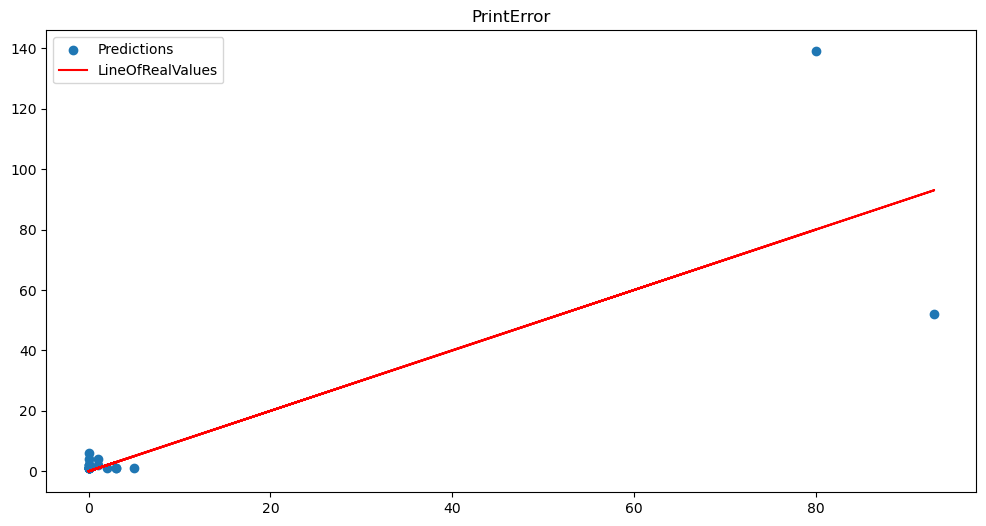

In [54]:
#Chart to show the closeness of the PrintError predictions to the true values is being plaotted
DrawChart('PrintError', testFrame['PrintError'],  testFrame['PredictedPrintError'])

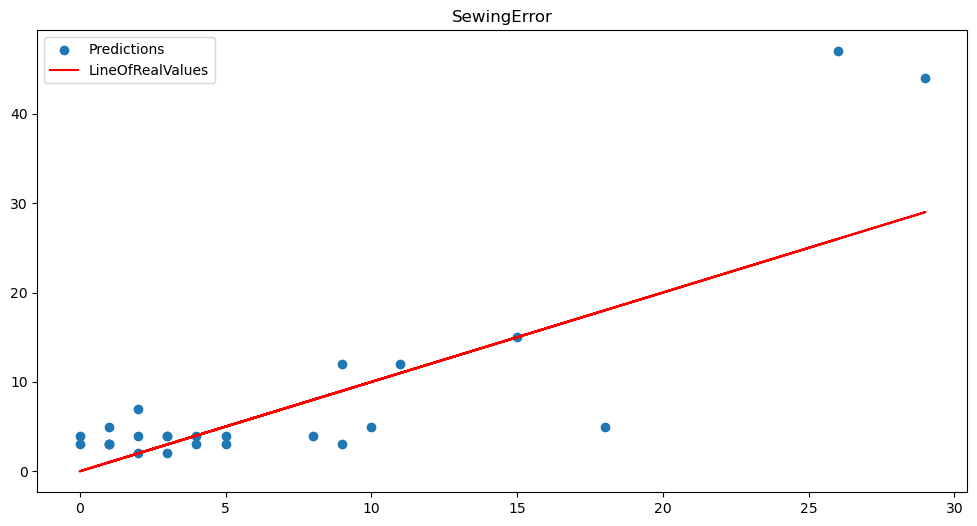

In [55]:
#Chart to show the closeness of the SewingError predictions to the true values is being plaotted
DrawChart('SewingError', testFrame['SewingError'],  testFrame['PredictedSewingError'])

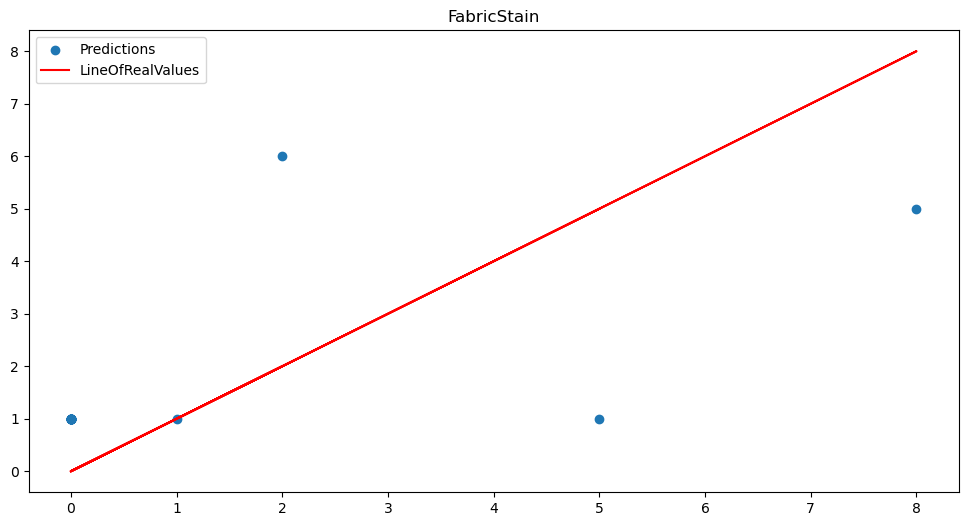

In [56]:
#Chart to show the closeness of the FabricStain predictions to the true values is being plaotted
DrawChart('FabricStain', testFrame['FabricStain'],  testFrame['PredictedFabricStain'])

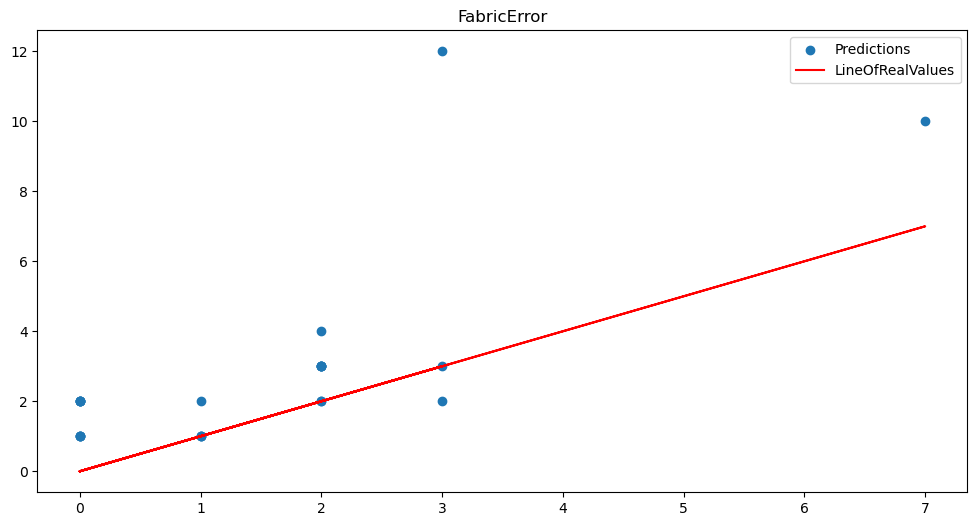

In [57]:
#Chart to show the closeness of the FabricError predictions to the true values is being plaotted
DrawChart('FabricError', testFrame['FabricError'],  testFrame['PredictedFabricError'])

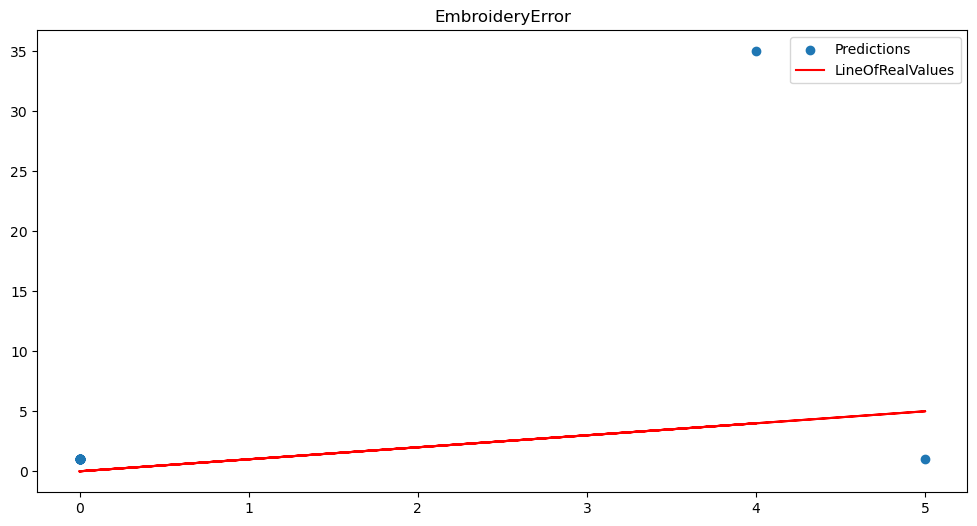

In [58]:
#Chart to show the closeness of the EmbroideryError predictions to the true values is being plaotted
DrawChart('EmbroideryError', testFrame['EmbroideryError'],  testFrame['PredictedEmbroideryError'])

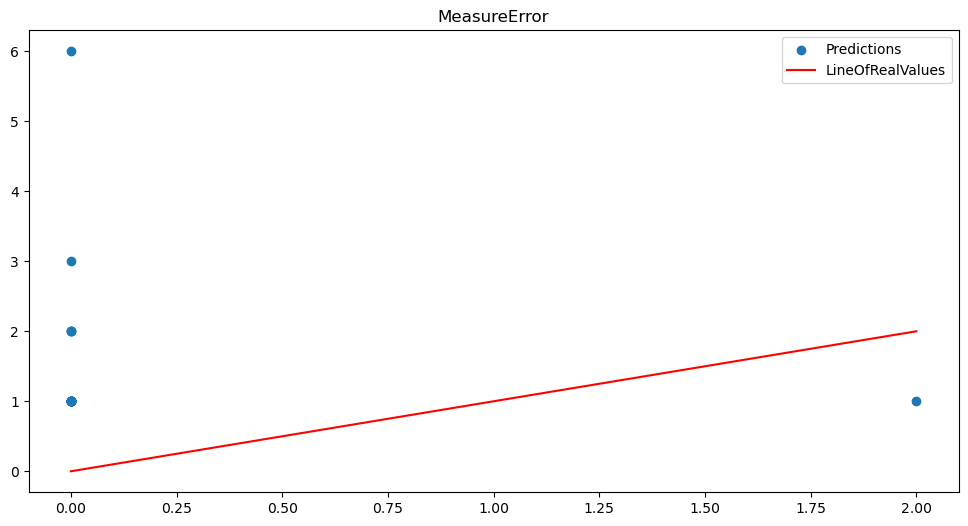

In [59]:
#Chart to show the closeness of the MeasureError predictions to the true values is being plaotted
DrawChart('MeasureError', testFrame['MeasureError'],  testFrame['PredictedMeasureError'])

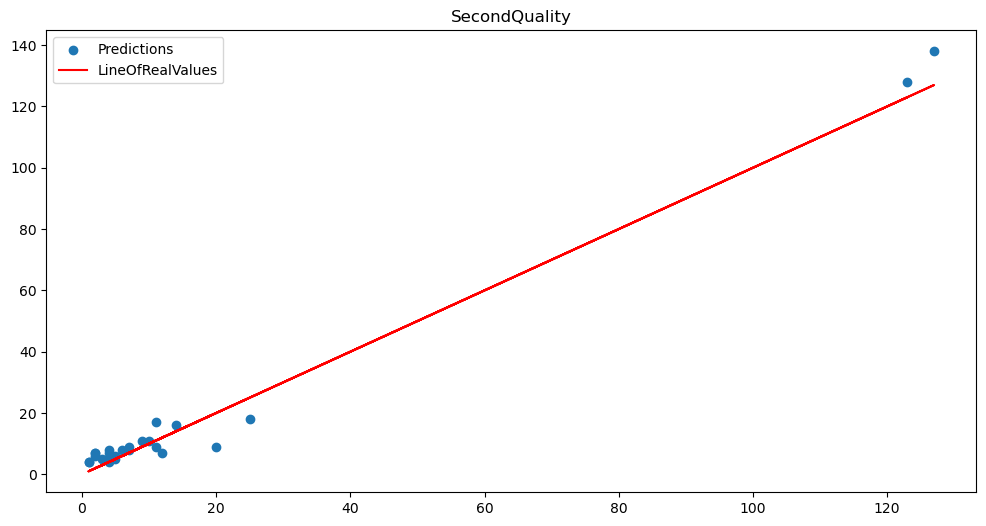

In [60]:
#Chart to show the closeness of the SecondQuality predictions to the true values is being plaotted
DrawChart('SecondQuality', testFrame['SecondQuality'],  testFrame['PredictedSecondQuality'])

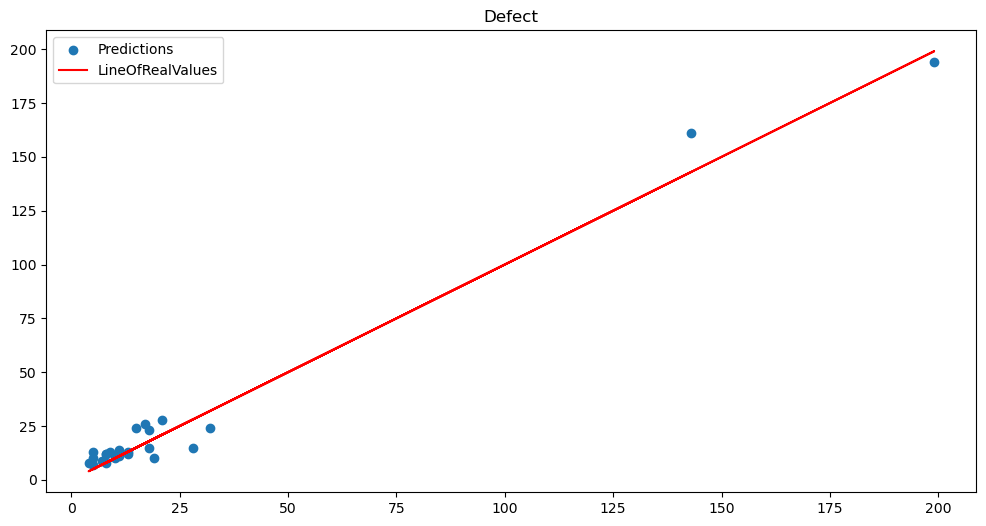

In [61]:
#Chart to show the closeness of the Defect predictions to the true values is being plaotted
DrawChart('Defect', testFrame['Defect'],  testFrame['PredictedDefect'])